In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

## Get the data

In [2]:
from graphtda.datasets import get_dataset, read_classes
from graphtda.reader import tud_to_networkx

In [3]:
get_dataset("PROTEINS")

array([1, 1, 1, ..., 2, 2, 2])

In [4]:
data = tud_to_networkx("PROTEINS")

In [5]:
y = read_classes("PROTEINS") -1
y

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
u, values = np.unique(y, return_counts=True)
print(u, values)

[0 1] [663 450]


In [7]:
values[0] / len(y) 

0.5956873315363881

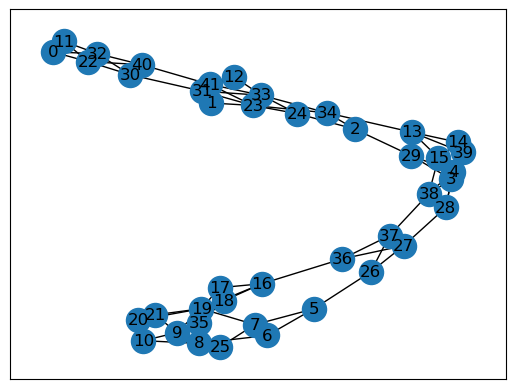

In [8]:
nx.draw_networkx(data[0])

# 1-parameter filtrations

## Compute ECC - degree filtration

In [9]:
from graphtda import FilteredGraph
from graphtda.graphtda import degree_filtration
from graphtda.bifiltration_utils import euler_characteristic_list_from_all, plot_euler_curve, EC_at_filtration

In [10]:
ECC_list = []

for G in tqdm(data):
    fg = FilteredGraph(G, filtration_function=degree_filtration)
    ecc_contributions = fg.compute_ECP()

    ECC_list.append(euler_characteristic_list_from_all(ecc_contributions))

  0%|          | 0/1113 [00:00<?, ?it/s]

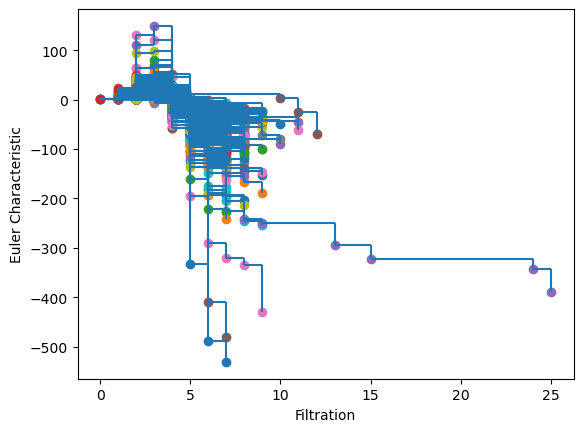

In [11]:
fig, ax = plt.subplots()
for ecc in ECC_list:
    plot_euler_curve(ecc, with_lines=True, this_ax=ax)

### Vectorize

In [12]:
# lets find the max filtration value
max_f = max([c[-1][0] for c in ECC_list])
max_f

25

In [13]:
# lets sample the ECCs
X = np.array([ [EC_at_filtration(ecc, i) for i in range(max_f+1)] for ecc in ECC_list])
X.shape

(1113, 26)

### Classify

In [14]:
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

0it [00:00, ?it/s]

TRAIN: 0.708 \pm 0.00542
TEST: 0.704 \pm 0.0218


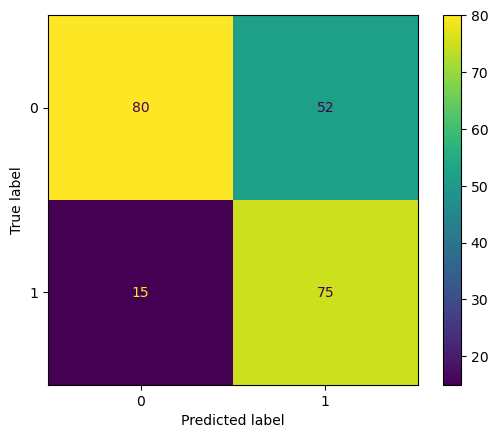

In [15]:
train_accuracy_SVM = []
test_accuracy_SVM = []

skf = StratifiedKFold(n_splits=5)
        
for train, test in tqdm(skf.split(X, y)):
    
    SVM_classifier = svm.SVC(kernel='rbf', 
                            class_weight='balanced', 
                            C=1,
                            random_state=42)
    SVM_classifier.fit(X[train], y[train])
    train_accuracy_SVM.append(SVM_classifier.score(X[train], y[train]))
    test_accuracy_SVM.append(SVM_classifier.score(X[test], y[test]))


print("TRAIN: {:.3} \pm {:.3}".format(np.mean(train_accuracy_SVM), np.std(train_accuracy_SVM)))
print("TEST: {:.3} \pm {:.3}".format(np.mean(test_accuracy_SVM), np.std(test_accuracy_SVM)))

predictions = SVM_classifier.predict(X[test])
cm = confusion_matrix(y[test], predictions, labels=SVM_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=SVM_classifier.classes_)
disp.plot()

plt.show()

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

0it [00:00, ?it/s]

TRAIN: 0.725 \pm 0.00613
TEST: 0.721 \pm 0.0174


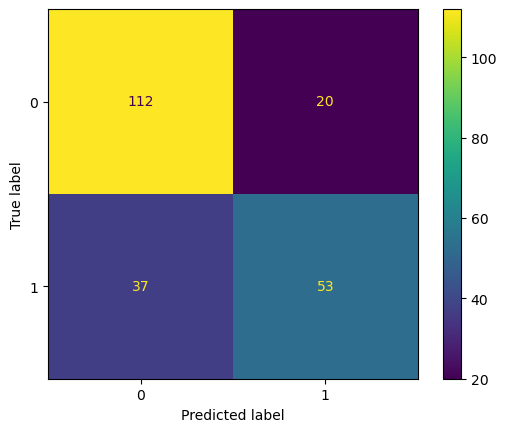

In [17]:
train_accuracy_LDA = []
test_accuracy_LDA = []

skf = StratifiedKFold(n_splits=5)
        
for train, test in tqdm(skf.split(X, y)):
    
    ldr_classifier = LinearDiscriminantAnalysis()

    ldr_classifier.fit(X[train], y[train])
    train_accuracy_LDA.append(ldr_classifier.score(X[train], y[train]))
    test_accuracy_LDA.append(ldr_classifier.score(X[test], y[test]))


print("TRAIN: {:.3} \pm {:.3}".format(np.mean(train_accuracy_LDA), np.std(train_accuracy_LDA)))
print("TEST: {:.3} \pm {:.3}".format(np.mean(test_accuracy_LDA), np.std(test_accuracy_LDA)))

predictions = ldr_classifier.predict(X[test])
cm = confusion_matrix(y[test], predictions, labels=ldr_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ldr_classifier.classes_)
disp.plot()

plt.show()

# 2-parameter filtrations

In [9]:
from graphtda import FilteredGraph
from graphtda.graphtda import hks, ollivier_ricci_curvature, degree_filtration
from graphtda.graphtda import product_bifiltration

In [10]:
def graded_rank_at_value(betti, x,y):
    for i, this_x in enumerate(betti.dimensions.x_grades):
        if this_x > x:
            i -= 1
            break

    for j, this_y in enumerate(betti.dimensions.y_grades):
        if this_y > y:
            j -= 1
            break

    if j < 0 or i < 0:
        return 0
    return betti.graded_rank[j,i]

def discretize_graded_rank(betti, x_grid, y_grid):
    betti_grid = np.zeros((len(x_grid), len(y_grid)))

    for i, x in enumerate(x_grid):
        for j, y in enumerate(y_grid):
            betti_grid[i,j] = graded_rank_at_value(betti, x, y)

    # just to be consistent with pyRivet
    return betti_grid.T

In [11]:
hilbert_0 = []
hilbert_1 = []

hilbert_labels = []

for i, (G, label) in tqdm(enumerate(zip(data, y))):
    FG1 = FilteredGraph(G, hks, t=10)
    FG2 = FilteredGraph(G, ollivier_ricci_curvature, alpha=0.5)

    FG = FilteredGraph(G, product_bifiltration, G1=FG1, G2=FG2)

    FG.compute_bipersistence(dim=0, x=100,y=100)
    hilbert_0.append(FG.betti)

    FG.compute_bipersistence(dim=1, x=100,y=100)
    hilbert_1.append(FG.betti)

    hilbert_labels.append(label)

hilbert_labels = np.array(hilbert_labels)

0it [00:00, ?it/s]

In [12]:
x_min, x_max = (min([float(min(betti.dimensions.x_grades)) for betti in hilbert_0]), 
                max([float(max(betti.dimensions.x_grades)) for betti in hilbert_0])
)

y_min, y_max = (min([float(min(betti.dimensions.y_grades)) for betti in hilbert_0]), 
                max([float(max(betti.dimensions.y_grades)) for betti in hilbert_0])
)

print(x_min, x_max)
print(y_min, y_max)

0.0 1.0
-1.0 1.0


In [35]:
x_grid = np.linspace(x_min, x_max, num=50)
y_grid = np.linspace(y_min, y_max, num=50)

grid_hilbert_0 = np.array([discretize_graded_rank(betti, x_grid, y_grid) for betti in tqdm(hilbert_0)])

  0%|          | 0/1113 [00:00<?, ?it/s]

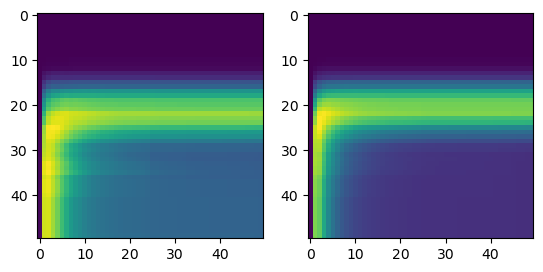

In [36]:
fig, axs = plt.subplots(ncols=2)

mean_grid_true = np.mean(grid_hilbert_0[y == 1], axis=0)
mean_grid_false = np.mean(grid_hilbert_0[y == 0], axis=0)
axs[0].imshow(mean_grid_true)
axs[1].imshow(mean_grid_false)

In [37]:
# for img in grid_hilbert_0[:5]:
#     plt.imshow(img)
#     plt.show()

## Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

In [22]:
X_train.reshape(len(X_train), -1).shape

(890, 400)

In [24]:
train_accuracy_CNN = []
test_accuracy_CNN = []

skf = StratifiedKFold(n_splits=5)
        
for train, test in tqdm(skf.split(grid_hilbert_0, hilbert_labels)):
    X_train = grid_hilbert_0[train].reshape(len(train), -1)
    X_test = grid_hilbert_0[test].reshape(len(test), -1)
    y_train = hilbert_labels[train]
    y_test = hilbert_labels[test]

    clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0,
                                     max_depth=1, random_state=0).fit(X_train, y_train)

    print(clf.score(X_test, y_test))

0it [00:00, ?it/s]

0.6547085201793722
0.6771300448430493
0.672645739910314
0.6936936936936937
0.6666666666666666


## ConvNN 

In [46]:
from sklearn.model_selection import train_test_split, StratifiedKFold


import torch
import torch.nn as nn
import torch.optim as optim


class ConvNet(nn.Module):
    def __init__(self, dropout_prob=0):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2), nn.ReLU(True)
        )
        # nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(True)
        )
        # nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(p=dropout_prob)
        self.relu = torch.nn.ReLU()

        self.fc1 = nn.Linear(5 * 5 * 16, 100)
        self.fcOut = nn.Linear(100, 2)

    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)

        out = out.reshape(out.size(0), -1)

        out = self.drop_out(out)

        out = self.fc1(out)
        out = self.drop_out(out)
        out = self.relu(out)
        out = self.fcOut(out)
        return out


# Use this function to evaluate your model
def accuracy(y_pred, y_true):
    """
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    """
    return (1.0 * (y_pred == y_true)).mean()


In [47]:
train_accuracy_CNN = []
test_accuracy_CNN = []

skf = StratifiedKFold(n_splits=5)
        
for train, test in tqdm(skf.split(grid_hilbert_0, hilbert_labels)):
    X_train = grid_hilbert_0[train]
    X_test = grid_hilbert_0[test]
    y_train = hilbert_labels[train]
    y_test = hilbert_labels[test]

    ### Training

    num_epochs = 20

    # initialize the net
    net = ConvNet(dropout_prob=0.25)

    device = torch.device("cpu")
    # Move all the network parameters to the selected device
    net.to(device)

    ### Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    ### Define an optimizer
    lr = 5e-4
    wd = 1e-4
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

    # create the dataloaders
    train_data = torch.utils.data.TensorDataset(
        torch.tensor(X_train).float(), torch.tensor(y_train.astype(int).reshape(-1))
    )
    test_data = torch.utils.data.TensorDataset(
        torch.tensor(X_test).float(), torch.tensor(y_test.astype(int).reshape(-1))
    )

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=100, shuffle=False
    )

    for num_epoch in range(num_epochs):
        # Training
        net.train()  # Training mode (e.g. enable dropout)
        # Eventually clear previous recorded gradients
        optimizer.zero_grad()

        for batch_idx, (train_data, train_label) in enumerate(train_loader):
            # Eventually clear previous recorded gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            input_batch = train_data.unsqueeze(1).to(device)

            outputs = net(input_batch)

            loss = loss_fn(outputs, train_label.to(device))

            loss.backward()
            optimizer.step()

    ## accuracy
    # train
    input_train = torch.tensor(X_train).float()
    label_train = y_train

    with torch.no_grad():
        outputs = net(input_train.unsqueeze(1).to(device)).cpu()
        softmax = nn.functional.softmax(outputs, dim = 1)
        predicted_label = np.argmax(softmax, axis=1).numpy()

    train_accuracy_CNN.append(accuracy(predicted_label, label_train))

    # test
    input_test = torch.tensor(X_test).float()
    label_test = y_test

    with torch.no_grad():
        outputs = net(input_test.unsqueeze(1).to(device)).cpu()
        softmax = nn.functional.softmax(outputs, dim = 1)
        predicted_label = np.argmax(softmax, axis=1).numpy()


    test_accuracy_CNN.append(accuracy(predicted_label, label_test))

0it [00:00, ?it/s]

In [48]:
print("TRAIN: {:.3} \pm {:.3}".format(np.mean(train_accuracy_CNN), np.std(train_accuracy_CNN)))
print("TEST: {:.3} \pm {:.3}".format(np.mean(test_accuracy_CNN), np.std(test_accuracy_CNN)))

TRAIN: 0.728 \pm 0.00492
TEST: 0.715 \pm 0.00615
